# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch as torch
import torch.nn.functional as F
from torch import optim as optim
import matplotlib.pyplot as plt
from collections import namedtuple,deque
import random
import copy

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations        # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.09000000171363354


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [8]:
REPLAY_BUFFER_SIZE = int(1e6)
VISUALIZE_EVERY = 50 #how many episodes to train before watching unity env simulation
PRINT_EVERY = 10 #how many steps to train before printing training info
DESIRED_EPISODES_AVERAGE = 100
DESIRED_AVERAGE_SCORE = 0.5
TRAIN_EVERY = 5
BATCH_SIZE = 512
UPDATE_TARGET_NETWORK_EVERY = 20
TAU = 1e-3 
SEED=0

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples for experience replay"""
    
    def __init__(self,action_size,buffer_size):
        """Initialize a ReplayBuffer objectParams
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
        """
        
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience",field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self,state,action,reward,next_state,done):
        "Add a new experience tuple to replay buffer"
        new_experience = self.experience(state,action,reward,next_state,done)
        self.memory.append(new_experience)
        
    def sample(self,batch_size):
        "Get a sample of the buffer of size=batch size"
        experience_batch = random.sample(self.memory,k=batch_size)
        
        states =  torch.from_numpy(np.vstack([e.state  for e in experience_batch if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experience_batch if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experience_batch if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experience_batch if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experience_batch if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        """Return the current size of internal memory"""
        return len(self.memory)

In [11]:
class OUNoise:
    """
        Orstein-Ulenbeck process
        used to add noise to actor selections for adding exploratoion
    """
    def __init__(self,size,mu=0.0,theta=0.15,sigma=0.2):
        self.size = size
        self.mu = mu*np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()
        
    def reset(self):
        self.state = copy.copy(self.mu)
        
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        
        return self.state

In [12]:
def hidden_init(layer):
    """Used to set the initial weights of hidden layers"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [13]:

# one actor will be shared by the 2 players, trained by self-play
class Actor(torch.nn.Module):
    def __init__(self,state_size,action_size):
        super(Actor,self).__init__()
        self.action_size = action_size
        #self.bn=   torch.nn.BatchNorm1d(state_size)
        self.fc1 = torch.nn.Linear(state_size,400)
        self.fc2 = torch.nn.Linear(400,300)
        self.fc_output = torch.nn.Linear(300,action_size)
        self.reset_parameters()
        
    def forward(self,x):
        #x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        y = F.tanh(self.fc_output(x))
        
        return y
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc_output.weight.data.uniform_(-0.0001, 0.0001)

In [14]:
# one critic will be shared by the 2 players, trianed by self-play
class Critic(torch.nn.Module):
    def __init__(self,state_size,action_size):
        super(Critic,self).__init__()
        self.fc1 = torch.nn.Linear(state_size+ action_size,400) #use actions of both agent
        self.fc2 = torch.nn.Linear(400,300)
        self.fc_output = torch.nn.Linear(300,1)
        self.reset_parameters()
        
    def forward(self,x,actions):
        x = torch.cat((x,actions),dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        y = self.fc_output(x)
        
        return y
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc_output.weight.data.uniform_(-3e-4, 3e-4)

In [15]:
class Agent:
    def __init__(self,state_size,action_size,actor_local,replay_buffer,device):
        self.action_size  = action_size
        self.actor_local = actor_local
        self.device = device
        
        self.replay_buffer = replay_buffer
        
        self.noise = OUNoise(size=action_size)
        
    def act(self,state):
        
        state = torch.from_numpy(state).float().unsqueeze(0).detach().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()
        noise = self.noise.sample()
        action = np.clip(action + noise ,-1,1)
        
        return action

In [16]:
def update_target_network(local_network,target_network,tau):
    for target_param,local_param in zip(target_network.parameters(),local_network.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)

In [17]:
replay_buffer = ReplayBuffer(action_size,REPLAY_BUFFER_SIZE)

actor_local = Actor(state_size,action_size).to(device)
critic_local = Critic(state_size,action_size).to(device)

actor_target = Actor(state_size,action_size).to(device)
critic_target = Critic(state_size,action_size).to(device)

update_target_network(actor_local,actor_target,1.0)
update_target_network(critic_local,critic_target,1.0)

critic_optimizer = optim.Adam(critic_local.parameters(),lr=1e-4 )
actor_optimizer = optim.Adam(actor_local.parameters(),lr=1e-3)

agent1 = Agent(state_size,action_size,actor_local,replay_buffer,device)
agent2 = Agent(state_size,action_size,actor_local,replay_buffer,device)

In [18]:
def train(batch_size=32,step_num=0,print_every = 100,critic_losses=[],actor_losses = []):
    (states, actions, rewards, next_states, dones) = replay_buffer.sample(batch_size)
    
    #actor_target.eval()
    #critic_target.eval()
    
    next_target_actions = actor_target(next_states)
    with torch.no_grad():
        #next_target_actions = actor_target(next_states)
        target_q_values = critic_target(next_states,next_target_actions)
    target_return = rewards + (0.99*target_q_values*(1-dones))
    
    #train critic
    #critic_local.train()
    
    current_critic_estimate = critic_local(states,actions)
    critic_mse_loss = F.mse_loss(current_critic_estimate,target_return.detach())
    
    critic_optimizer.zero_grad()
    critic_mse_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic_local.parameters(),1)
    critic_optimizer.step()
    
    critic_losses.append(critic_mse_loss)
    
    #train actor
    local_actions = actor_local(states)
    actor_loss = -critic_local(states,local_actions).mean()
    
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    actor_losses.append(actor_loss)

In [19]:
def main(agent1,agent2,episodes,visualize_every,print_every):
    total_rewards = [[],[]]
    critic_losses = []
    actor_losses = []
    episode_single_scores = [] # the max between scores of both agents
    episode_window_scores = deque(maxlen = DESIRED_EPISODES_AVERAGE)
    
    for episode in range(1,episodes +1):
        finished = False
        step_count = 0
        episode_scores = np.zeros(num_agents)
        
        agent1.noise.reset()
        agent2.noise.reset()
        train_mode = not(episode%visualize_every == 0)
        env_info = env.reset(train_mode = train_mode)[brain_name]
        states = env_info.vector_observations
        
        while not finished:
            actions_ag1 = agent1.act(states[0])
            #print(actions_ag1)
            #actions_ag2 = agent2.act(states[1])
            actions_ag2 = np.random.randn(1, action_size)
            env_info = env.step(np.concatenate((actions_ag1,actions_ag2),axis=0))[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            #add experience to shared replay buffer
            #if np.sum(rewards) != 0.0:
            replay_buffer.add(states[0],actions_ag1,rewards[0],next_states[0],dones[0])
            replay_buffer.add(states[1],actions_ag2,rewards[1],next_states[1],dones[1])
            
            states = next_states
            
            episode_scores += rewards
            finished = dones[0] or dones[1]
            
            if step_count % TRAIN_EVERY == 0 and len(replay_buffer) >= BATCH_SIZE:
                train(critic_losses = critic_losses,actor_losses = actor_losses)
                
            if step_count % UPDATE_TARGET_NETWORK_EVERY == 0 and len(replay_buffer) >= BATCH_SIZE:
                update_target_network(actor_local,actor_target,TAU)
                update_target_network(critic_local,critic_target,TAU)
                
            step_count += 1
            
            
        episode_single_score = max(episode_scores)
        episode_window_scores.append(episode_single_score)
        episode_single_scores.append(episode_single_score)
        
        total_rewards[0].append(episode_scores[0])
        total_rewards[1].append(episode_scores[1])
        
        if episode % print_every == 0:
            print("Episode:{} steps:{} episode_reward:{} last n mean rew.{},individual episode rew.{}".format(episode, step_count,
                                                                                    episode_single_score,np.mean(episode_window_scores),episode_scores))
                
        
        if np.mean(episode_window_scores) >= DESIRED_AVERAGE_SCORE:
            print("Solved in {} episodes".format(episode))
            checkpoint_name = "checkpoint_solved_"+str(episode)+".pth"
            break
            
    return total_rewards,critic_losses,actor_losses,episode_single_scores

train_rewards,critic_losses,actor_losses,episode_single_scores = main(agent1,agent2,10000,VISUALIZE_EVERY,PRINT_EVERY)

Episode:10 steps:16 episode_reward:0.0 last n mean rew.0.010000000149011612,individual episode rew.[-0.01  0.  ]
Episode:20 steps:14 episode_reward:0.0 last n mean rew.0.005000000074505806,individual episode rew.[ 0.   -0.01]
Episode:30 steps:14 episode_reward:0.0 last n mean rew.0.0063333334401249886,individual episode rew.[-0.01  0.  ]
Episode:40 steps:15 episode_reward:0.0 last n mean rew.0.004750000080093741,individual episode rew.[-0.01  0.  ]
Episode:50 steps:15 episode_reward:0.0 last n mean rew.0.009600000157952308,individual episode rew.[ 0.   -0.01]
Episode:60 steps:14 episode_reward:0.0 last n mean rew.0.0125000002173086,individual episode rew.[-0.01  0.  ]
Episode:70 steps:15 episode_reward:0.0 last n mean rew.0.010714285900550229,individual episode rew.[-0.01  0.  ]
Episode:80 steps:14 episode_reward:0.0 last n mean rew.0.01050000018440187,individual episode rew.[-0.01  0.  ]
Episode:90 steps:14 episode_reward:0.0 last n mean rew.0.011333333535326852,individual episode rew

Episode:720 steps:14 episode_reward:0.0 last n mean rew.0.010400000177323818,individual episode rew.[ 0.   -0.01]
Episode:730 steps:15 episode_reward:0.0 last n mean rew.0.011300000194460154,individual episode rew.[ 0.   -0.01]
Episode:740 steps:14 episode_reward:0.0 last n mean rew.0.010300000179558993,individual episode rew.[ 0.   -0.01]
Episode:750 steps:14 episode_reward:0.0 last n mean rew.0.007400000132620334,individual episode rew.[-0.01  0.  ]
Episode:760 steps:33 episode_reward:0.09000000171363354 last n mean rew.0.009300000164657832,individual episode rew.[0.   0.09]
Episode:770 steps:14 episode_reward:0.0 last n mean rew.0.007500000130385161,individual episode rew.[ 0.   -0.01]
Episode:780 steps:14 episode_reward:0.0 last n mean rew.0.006600000113248825,individual episode rew.[-0.01  0.  ]
Episode:790 steps:15 episode_reward:0.0 last n mean rew.0.007600000128149986,individual episode rew.[-0.01  0.  ]
Episode:800 steps:15 episode_reward:0.0 last n mean rew.0.0085000001452863

Episode:1430 steps:14 episode_reward:0.0 last n mean rew.0.008400000147521496,individual episode rew.[-0.01  0.  ]
Episode:1440 steps:14 episode_reward:0.0 last n mean rew.0.006500000115484,individual episode rew.[ 0.   -0.01]
Episode:1450 steps:15 episode_reward:0.0 last n mean rew.0.006500000115484,individual episode rew.[-0.01  0.  ]
Episode:1460 steps:30 episode_reward:0.09000000171363354 last n mean rew.0.006400000117719173,individual episode rew.[0.   0.09]
Episode:1470 steps:13 episode_reward:0.0 last n mean rew.0.006400000117719173,individual episode rew.[-0.01  0.  ]
Episode:1480 steps:14 episode_reward:0.0 last n mean rew.0.006500000115484,individual episode rew.[ 0.   -0.01]
Episode:1490 steps:16 episode_reward:0.0 last n mean rew.0.007400000132620334,individual episode rew.[ 0.   -0.01]
Episode:1500 steps:14 episode_reward:0.0 last n mean rew.0.010300000179558993,individual episode rew.[-0.01  0.  ]
Episode:1510 steps:14 episode_reward:0.0 last n mean rew.0.0112000001966953

Episode:2120 steps:33 episode_reward:0.10000000149011612 last n mean rew.0.02220000037923455,individual episode rew.[ 0.1  -0.01]
Episode:2130 steps:14 episode_reward:0.0 last n mean rew.0.02020000034943223,individual episode rew.[ 0.   -0.01]
Episode:2140 steps:14 episode_reward:0.0 last n mean rew.0.02020000034943223,individual episode rew.[ 0.   -0.01]
Episode:2150 steps:31 episode_reward:0.09000000171363354 last n mean rew.0.020100000351667403,individual episode rew.[0.   0.09]
Episode:2160 steps:15 episode_reward:0.0 last n mean rew.0.018000000324100256,individual episode rew.[-0.01  0.  ]
Episode:2170 steps:14 episode_reward:0.0 last n mean rew.0.019000000320374966,individual episode rew.[-0.01  0.  ]
Episode:2180 steps:15 episode_reward:0.0 last n mean rew.0.01710000028833747,individual episode rew.[ 0.   -0.01]
Episode:2190 steps:14 episode_reward:0.0 last n mean rew.0.013300000224262476,individual episode rew.[-0.01  0.  ]
Episode:2200 steps:14 episode_reward:0.0 last n mean r

Episode:2830 steps:17 episode_reward:0.0 last n mean rew.0.016800000313669444,individual episode rew.[ 0.   -0.01]
Episode:2840 steps:14 episode_reward:0.0 last n mean rew.0.015900000296533108,individual episode rew.[-0.01  0.  ]
Episode:2850 steps:15 episode_reward:0.0 last n mean rew.0.014900000281631947,individual episode rew.[ 0.   -0.01]
Episode:2860 steps:15 episode_reward:0.0 last n mean rew.0.015700000301003457,individual episode rew.[ 0.   -0.01]
Episode:2870 steps:20 episode_reward:0.0 last n mean rew.0.014600000288337469,individual episode rew.[ 0.   -0.01]
Episode:2880 steps:15 episode_reward:0.0 last n mean rew.0.012600000239908695,individual episode rew.[ 0.   -0.01]
Episode:2890 steps:14 episode_reward:0.0 last n mean rew.0.013700000252574682,individual episode rew.[ 0.   -0.01]
Episode:2900 steps:15 episode_reward:0.0 last n mean rew.0.018600000329315663,individual episode rew.[-0.01  0.  ]
Episode:2910 steps:15 episode_reward:0.0 last n mean rew.0.018600000329315663,in

Episode:3540 steps:14 episode_reward:0.0 last n mean rew.0.006400000117719173,individual episode rew.[-0.01  0.  ]
Episode:3550 steps:32 episode_reward:0.09000000171363354 last n mean rew.0.007300000134855509,individual episode rew.[0.   0.09]
Episode:3560 steps:14 episode_reward:0.0 last n mean rew.0.007300000134855509,individual episode rew.[-0.01  0.  ]
Episode:3570 steps:30 episode_reward:0.09000000171363354 last n mean rew.0.007200000137090683,individual episode rew.[0.   0.09]
Episode:3580 steps:14 episode_reward:0.0 last n mean rew.0.007200000137090683,individual episode rew.[ 0.   -0.01]
Episode:3590 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[-0.01  0.  ]
Episode:3600 steps:14 episode_reward:0.0 last n mean rew.0.009200000166893006,individual episode rew.[-0.01  0.  ]
Episode:3610 steps:15 episode_reward:0.0 last n mean rew.0.01010000018402934,individual episode rew.[ 0.   -0.01]
Episode:3620 steps:15 episode_reward:0.0 last n mean 

Episode:4240 steps:14 episode_reward:0.0 last n mean rew.0.009300000164657832,individual episode rew.[ 0.   -0.01]
Episode:4250 steps:15 episode_reward:0.0 last n mean rew.0.007500000130385161,individual episode rew.[-0.01  0.  ]
Episode:4260 steps:14 episode_reward:0.0 last n mean rew.0.008400000147521496,individual episode rew.[ 0.   -0.01]
Episode:4270 steps:14 episode_reward:0.0 last n mean rew.0.008400000166147947,individual episode rew.[-0.01  0.  ]
Episode:4280 steps:14 episode_reward:0.0 last n mean rew.0.008400000166147947,individual episode rew.[-0.01  0.  ]
Episode:4290 steps:14 episode_reward:0.0 last n mean rew.0.011100000217556954,individual episode rew.[-0.01  0.  ]
Episode:4300 steps:14 episode_reward:0.0 last n mean rew.0.011000000219792128,individual episode rew.[ 0.   -0.01]
Episode:4310 steps:14 episode_reward:0.0 last n mean rew.0.011000000219792128,individual episode rew.[-0.01  0.  ]
Episode:4320 steps:14 episode_reward:0.0 last n mean rew.0.009100000187754632,in

Episode:4950 steps:14 episode_reward:0.0 last n mean rew.0.006700000111013651,individual episode rew.[-0.01  0.  ]
Episode:4960 steps:15 episode_reward:0.0 last n mean rew.0.00570000009611249,individual episode rew.[-0.01  0.  ]
Episode:4970 steps:14 episode_reward:0.0 last n mean rew.0.006600000113248825,individual episode rew.[-0.01  0.  ]
Episode:4980 steps:15 episode_reward:0.0 last n mean rew.0.006600000113248825,individual episode rew.[-0.01  0.  ]
Episode:4990 steps:14 episode_reward:0.0 last n mean rew.0.006500000115484,individual episode rew.[-0.01  0.  ]
Episode:5000 steps:14 episode_reward:0.0 last n mean rew.0.00830000014975667,individual episode rew.[-0.01  0.  ]
Episode:5010 steps:15 episode_reward:0.0 last n mean rew.0.009100000169128179,individual episode rew.[ 0.   -0.01]
Episode:5020 steps:15 episode_reward:0.0 last n mean rew.0.009100000169128179,individual episode rew.[ 0.   -0.01]
Episode:5030 steps:14 episode_reward:0.0 last n mean rew.0.009100000169128179,individ

Episode:5660 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[ 0.   -0.01]
Episode:5670 steps:14 episode_reward:0.0 last n mean rew.0.010000000186264514,individual episode rew.[-0.01  0.  ]
Episode:5680 steps:14 episode_reward:0.0 last n mean rew.0.010800000205636024,individual episode rew.[ 0.   -0.01]
Episode:5690 steps:14 episode_reward:0.0 last n mean rew.0.01170000022277236,individual episode rew.[ 0.   -0.01]
Episode:5700 steps:14 episode_reward:0.0 last n mean rew.0.010800000205636024,individual episode rew.[ 0.   -0.01]
Episode:5710 steps:14 episode_reward:0.0 last n mean rew.0.010800000205636024,individual episode rew.[ 0.   -0.01]
Episode:5720 steps:30 episode_reward:0.10000000149011612 last n mean rew.0.011800000220537185,individual episode rew.[-0.01  0.1 ]
Episode:5730 steps:14 episode_reward:0.0 last n mean rew.0.013700000252574682,individual episode rew.[-0.01  0.  ]
Episode:5740 steps:30 episode_reward:0.09000000171363354 last n m

Episode:6370 steps:14 episode_reward:0.0 last n mean rew.0.004700000081211329,individual episode rew.[ 0.   -0.01]
Episode:6380 steps:14 episode_reward:0.0 last n mean rew.0.003800000064074993,individual episode rew.[-0.01  0.  ]
Episode:6390 steps:14 episode_reward:0.0 last n mean rew.0.003800000064074993,individual episode rew.[ 0.   -0.01]
Episode:6400 steps:14 episode_reward:0.0 last n mean rew.0.004700000081211329,individual episode rew.[ 0.   -0.01]
Episode:6410 steps:14 episode_reward:0.0 last n mean rew.0.002800000049173832,individual episode rew.[-0.01  0.  ]
Episode:6420 steps:14 episode_reward:0.0 last n mean rew.0.002800000049173832,individual episode rew.[ 0.   -0.01]
Episode:6430 steps:15 episode_reward:0.0 last n mean rew.0.003700000066310167,individual episode rew.[ 0.   -0.01]
Episode:6440 steps:14 episode_reward:0.0 last n mean rew.0.00570000009611249,individual episode rew.[-0.01  0.  ]
Episode:6450 steps:15 episode_reward:0.0 last n mean rew.0.007600000128149986,ind

Episode:7080 steps:14 episode_reward:0.0 last n mean rew.0.008500000145286322,individual episode rew.[ 0.   -0.01]
Episode:7090 steps:14 episode_reward:0.0 last n mean rew.0.008500000145286322,individual episode rew.[ 0.   -0.01]
Episode:7100 steps:14 episode_reward:0.0 last n mean rew.0.007500000130385161,individual episode rew.[-0.01  0.  ]
Episode:7110 steps:15 episode_reward:0.0 last n mean rew.0.007400000132620334,individual episode rew.[-0.01  0.  ]
Episode:7120 steps:32 episode_reward:0.09000000171363354 last n mean rew.0.008200000151991843,individual episode rew.[0.   0.09]
Episode:7130 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[ 0.   -0.01]
Episode:7140 steps:15 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[ 0.   -0.01]
Episode:7150 steps:14 episode_reward:0.0 last n mean rew.0.009100000169128179,individual episode rew.[ 0.   -0.01]
Episode:7160 steps:15 episode_reward:0.0 last n mean rew.0.0091000

Episode:7790 steps:14 episode_reward:0.0 last n mean rew.0.007300000134855509,individual episode rew.[ 0.   -0.01]
Episode:7800 steps:14 episode_reward:0.0 last n mean rew.0.007300000134855509,individual episode rew.[-0.01  0.  ]
Episode:7810 steps:14 episode_reward:0.0 last n mean rew.0.006400000117719173,individual episode rew.[-0.01  0.  ]
Episode:7820 steps:14 episode_reward:0.0 last n mean rew.0.005500000100582838,individual episode rew.[-0.01  0.  ]
Episode:7830 steps:13 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[ 0.   -0.01]
Episode:7840 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[ 0.   -0.01]
Episode:7850 steps:14 episode_reward:0.0 last n mean rew.0.009300000164657832,individual episode rew.[ 0.   -0.01]
Episode:7860 steps:14 episode_reward:0.0 last n mean rew.0.009300000164657832,individual episode rew.[-0.01  0.  ]
Episode:7870 steps:14 episode_reward:0.0 last n mean rew.0.00830000014975667,ind

Episode:8500 steps:14 episode_reward:0.0 last n mean rew.0.005600000098347664,individual episode rew.[-0.01  0.  ]
Episode:8510 steps:15 episode_reward:0.0 last n mean rew.0.005600000098347664,individual episode rew.[ 0.   -0.01]
Episode:8520 steps:14 episode_reward:0.0 last n mean rew.0.003700000066310167,individual episode rew.[ 0.   -0.01]
Episode:8530 steps:14 episode_reward:0.0 last n mean rew.0.0018000000342726708,individual episode rew.[ 0.   -0.01]
Episode:8540 steps:61 episode_reward:0.20000000298023224 last n mean rew.0.004700000081211329,individual episode rew.[0.09 0.2 ]
Episode:8550 steps:14 episode_reward:0.0 last n mean rew.0.005600000098347664,individual episode rew.[-0.01  0.  ]
Episode:8560 steps:14 episode_reward:0.0 last n mean rew.0.007500000130385161,individual episode rew.[-0.01  0.  ]
Episode:8570 steps:14 episode_reward:0.0 last n mean rew.0.006600000113248825,individual episode rew.[ 0.   -0.01]
Episode:8580 steps:14 episode_reward:0.0 last n mean rew.0.006600

Episode:9210 steps:14 episode_reward:0.0 last n mean rew.0.006300000119954348,individual episode rew.[ 0.   -0.01]
Episode:9220 steps:14 episode_reward:0.0 last n mean rew.0.006300000119954348,individual episode rew.[-0.01  0.  ]
Episode:9230 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[ 0.   -0.01]
Episode:9240 steps:15 episode_reward:0.0 last n mean rew.0.00830000014975667,individual episode rew.[ 0.   -0.01]
Episode:9250 steps:32 episode_reward:0.09000000171363354 last n mean rew.0.009200000166893006,individual episode rew.[0.   0.09]
Episode:9260 steps:15 episode_reward:0.0 last n mean rew.0.01010000018402934,individual episode rew.[-0.01  0.  ]
Episode:9270 steps:14 episode_reward:0.0 last n mean rew.0.00830000014975667,individual episode rew.[ 0.   -0.01]
Episode:9280 steps:14 episode_reward:0.0 last n mean rew.0.007400000132620334,individual episode rew.[-0.01  0.  ]
Episode:9290 steps:14 episode_reward:0.0 last n mean rew.0.0083000001

Episode:9920 steps:14 episode_reward:0.0 last n mean rew.0.011000000201165675,individual episode rew.[-0.01  0.  ]
Episode:9930 steps:14 episode_reward:0.0 last n mean rew.0.01090000020340085,individual episode rew.[-0.01  0.  ]
Episode:9940 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[-0.01  0.  ]
Episode:9950 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[-0.01  0.  ]
Episode:9960 steps:31 episode_reward:0.10000000149011612 last n mean rew.0.009100000169128179,individual episode rew.[-0.01  0.1 ]
Episode:9970 steps:14 episode_reward:0.0 last n mean rew.0.008200000151991843,individual episode rew.[ 0.   -0.01]
Episode:9980 steps:14 episode_reward:0.0 last n mean rew.0.009100000169128179,individual episode rew.[-0.01  0.  ]
Episode:9990 steps:14 episode_reward:0.0 last n mean rew.0.009100000169128179,individual episode rew.[-0.01  0.  ]
Episode:10000 steps:14 episode_reward:0.0 last n mean rew.0.00910

In [20]:
for i in range(1, 10):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    agent1.noise.reset()
    agent2.noise.reset()
    while True:
        
        actions_ag1 = agent1.act(states[0])
        #actions_ag1 = [[1,-1]]
        actions_ag2 = agent2.act(states[1])
        #actions_ag2 = np.random.randn(1, action_size)
        #actions_ag2 = [[1,-1]]
        #print(actions_ag1,actions_ag2)
        env_info = env.step(np.concatenate((actions_ag1,actions_ag2),axis=0))[brain_name]
        next_states = env_info.vector_observations        # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        #print(states[0],states[1])
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0
Score (max over agents) from episode 6: 0.0
Score (max over agents) from episode 7: 0.0
Score (max over agents) from episode 8: 0.0
Score (max over agents) from episode 9: 0.0


#### Agent 1 rewards

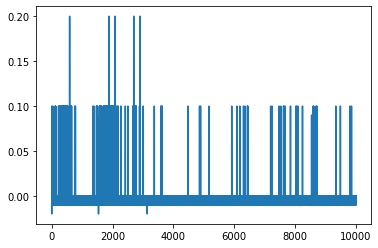

In [21]:
plt.plot(train_rewards[0])
plt.show()

#### Agent 2 rewards

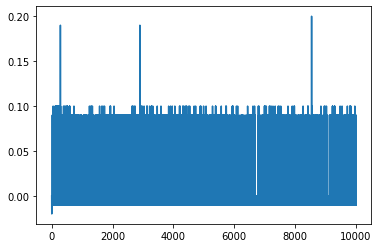

In [22]:
plt.plot(train_rewards[1])
plt.show()

### episode rewards

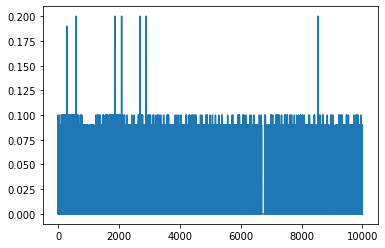

In [23]:
plt.plot(episode_single_scores)
plt.show()

#### Critic losses

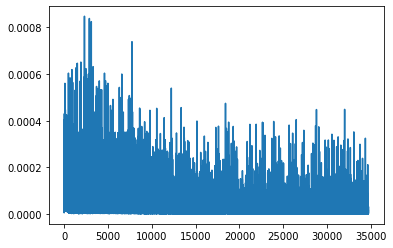

In [24]:
plt.plot(critic_losses)
plt.show()

### Actor losses

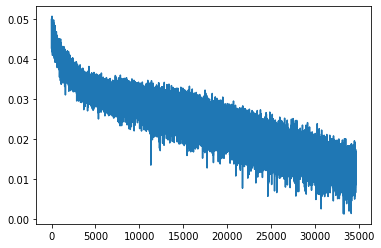

In [25]:
plt.plot(actor_losses)
plt.show()

In [26]:
noise = OUNoise(size=action_size)

for i in range(5):
    print("--------------------------")
    noise.reset()
    
    for j in range(100):
        sample = noise.sample()
        print("iteracion {} sample {}".format(i,sample))

In [27]:
agent1.actor_local.eval()
agent1.act(replay_buffer.sample(100)[0].cpu().numpy())

array([[[0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.89044853, 0.73811704],
        [0.890